In [1]:
import dill as dill
from os import listdir
from os.path import isfile, join
from fall_2021_projection_utils import aggregate_trajs, \
compute_log_likelihood_by_week, get_positives_by_week_from_traj

path = "fall_2021_prior_samples:1633381945"
files = [f for f in listdir(path) if isfile(join(path, f)) and 'with_trajectories' in f ]



In [30]:
sampled_points = {}
aggregated_trajs = {}

count = 0
for f in files:
    with open(join(path, f), "rb") as fhandle:
        [point, inf_trajs_by_group] = dill.load(fhandle)
        sampled_points[f] = point
        aggregated_trajs[f] = aggregate_trajs(inf_trajs_by_group)
    count += 1
    if count % 10 == 0:
        print("Loaded {} points".format(count))
        #break
    
        
        

Loaded 10 points
Loaded 20 points
Loaded 30 points
Loaded 40 points
Loaded 50 points
Loaded 60 points
Loaded 70 points
Loaded 80 points
Loaded 90 points
Loaded 100 points
Loaded 110 points
Loaded 120 points
Loaded 130 points
Loaded 140 points
Loaded 150 points
Loaded 160 points
Loaded 170 points
Loaded 180 points
Loaded 190 points
Loaded 200 points
Loaded 210 points
Loaded 220 points
Loaded 230 points
Loaded 240 points
Loaded 250 points
Loaded 260 points
Loaded 270 points
Loaded 280 points
Loaded 290 points
Loaded 300 points
Loaded 310 points
Loaded 320 points
Loaded 330 points
Loaded 340 points
Loaded 350 points
Loaded 360 points
Loaded 370 points
Loaded 380 points
Loaded 390 points
Loaded 400 points
Loaded 410 points
Loaded 420 points
Loaded 430 points
Loaded 440 points
Loaded 450 points
Loaded 460 points
Loaded 470 points
Loaded 480 points
Loaded 490 points
Loaded 500 points
Loaded 510 points
Loaded 520 points
Loaded 530 points
Loaded 540 points
Loaded 550 points
Loaded 560 points
L

In [31]:
import numpy as np

def convert_cum_traj_to_daily_count(traj):
    prev_cum_cases = 0
    daily_count = []
    for current_cum_cases in traj:
        daily_count.append(current_cum_cases - prev_cum_cases)
        prev_cum_cases = current_cum_cases
    return daily_count

def convert_daily_count_traj_to_weekly_count(daily_count_traj):
    weekly_count = []
    lower_idx = 0
    upper_idx = 7 
    while lower_idx <= len(daily_count_traj):
        weekly_count.append(sum(daily_count_traj[lower_idx:upper_idx]))
        lower_idx = upper_idx
        upper_idx += 7
    assert(np.abs(sum(weekly_count) - sum(daily_count_traj)) < 1e-5)
    return weekly_count

def get_weekly_counts(cum_traj):
    daily_count = convert_cum_traj_to_daily_count(cum_traj)
    return convert_daily_count_traj_to_weekly_count(daily_count)


    

In [32]:
from scipy.stats import norm

ACTUAL_TRAJ = [2,2,11,23,42,57,55,39,31,48,42,25,29,4,9,8,13,14,8,8,1,7,8,5,3,6,3,0,3,4,9,3,8,1]#,0,0]

def compute_lognormal_loglik(cum_trajs):
    actual_weekly_traj = convert_daily_count_traj_to_weekly_count(ACTUAL_TRAJ)
    num_weeks = len(actual_weekly_traj)
    
    # estimate lognormal parameters
    log_counts_by_week = {week_idx:[] for week_idx in range(num_weeks)}
    for cum_traj in cum_trajs:
        weekly_counts = get_weekly_counts(cum_traj)
        for week_idx in range(num_weeks):
            log_counts_by_week[week_idx].append(np.log(weekly_counts[week_idx]))
    
    means_by_week = {week_idx: np.mean(log_counts_by_week[week_idx]) for week_idx in range(num_weeks)}
    stddevs_by_week = {week_idx: np.std(log_counts_by_week[week_idx]) for week_idx in range(num_weeks)}
    
    # compute log likelihood for observed data
    loglik = 0
    for week_idx, actual_positives in enumerate(actual_weekly_traj):
        log_positives = np.log(actual_positives)
        scaled_log_positives = (log_positives - means_by_week[week_idx]) / stddevs_by_week[week_idx]
        #print(log_positives, means_by_week[week_idx], stddevs_by_week[week_idx], scaled_log_positives)
        loglik += np.log(norm.pdf(scaled_log_positives))
    
    return loglik

#compute_lognormal_loglik(aggregated_trajs[f])

In [33]:
import numpy as np
logliks = {}
for f in sampled_points:
    logliks[f] = compute_lognormal_loglik(aggregated_trajs[f])
    #print("\n\n\n")

/home/jmc678/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/home/jmc678/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/home/jmc678/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [35]:
from fall_2021_projection_utils import UNCERTAINTY_PARAMS

param_vals = {}
param_logliks = {}

for idx, param in enumerate(UNCERTAINTY_PARAMS):
    param_vals[param] = []
    param_logliks[param] = []
    for f in sampled_points:
        param_vals[param].append(sampled_points[f][idx])
        param_logliks[param].append(logliks[f])
    

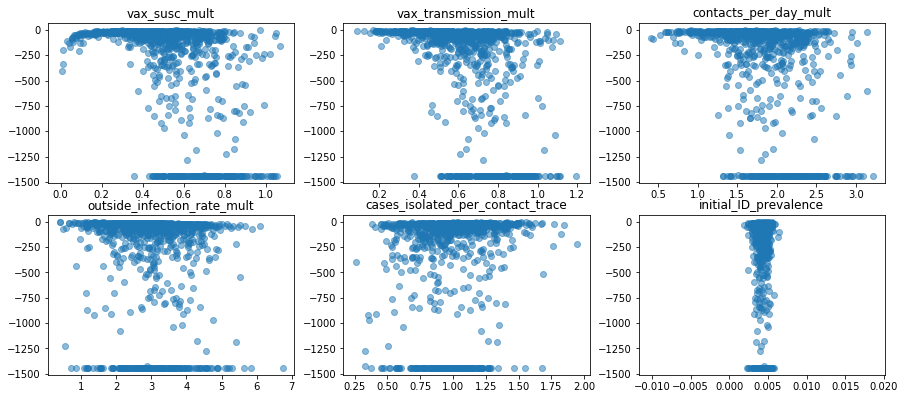

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,10))

for idx, param in enumerate(UNCERTAINTY_PARAMS):
    min_val = min([x for x in param_logliks[param] if x != float('-inf')])

    plt.subplot(3,3,idx+1)
    plt.scatter(param_vals[param], 
                [x if x != float('-inf') else min_val for x in param_logliks[param]],
               alpha=0.5)
    #plt.xlabel("Parameter Value")
    #plt.ylabel("Estimated Log Likelihood")
    plt.title("{}".format(param))

In [44]:
import pandas as pd
df = pd.DataFrame(param_vals)
df['log_likelihood'] = param_logliks[UNCERTAINTY_PARAMS[0]]
df['combined_spread_mult'] = df['vax_transmission_mult'] * df['vax_susc_mult'] * \
                                      df['contacts_per_day_mult']
min_loglik = min(df[df['log_likelihood'] > -np.inf]['log_likelihood'])
df.replace(-np.inf, min_loglik, inplace=True)
df.shape

(1000, 8)

Text(0.5,1,'distribution of log-normal log-likelihoods')

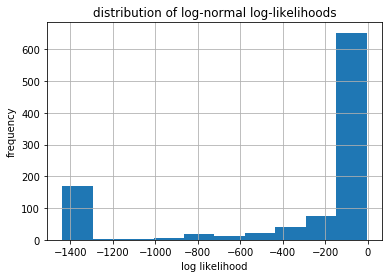

In [47]:
df['log_likelihood'].hist()
plt.xlabel('log likelihood')
plt.ylabel('frequency')
plt.title('distribution of log-normal log-likelihoods')

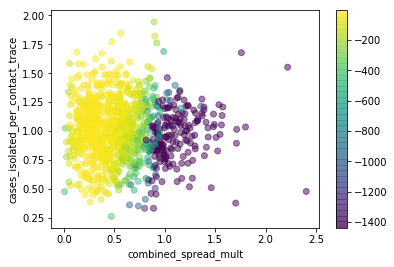

In [48]:
plt.scatter(df['combined_spread_mult'], df['cases_isolated_per_contact_trace'],
           c=df['log_likelihood'], alpha=0.5)
plt.xlabel('combined_spread_mult')
plt.ylabel('cases_isolated_per_contact_trace')
plt.colorbar()

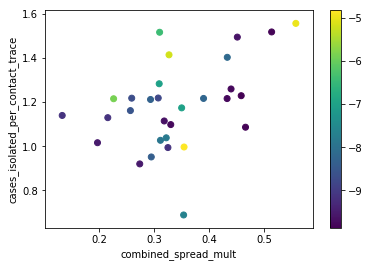

In [54]:
subdf = df[df['log_likelihood'] >= -10]
plt.scatter(subdf['combined_spread_mult'], subdf['cases_isolated_per_contact_trace'],
           c=subdf['log_likelihood'])
plt.xlabel('combined_spread_mult')
plt.ylabel('cases_isolated_per_contact_trace')
plt.colorbar()

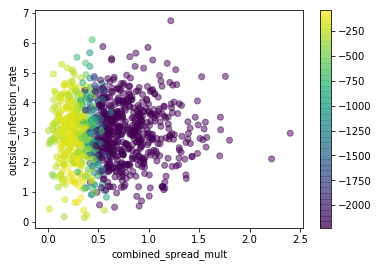

In [34]:
plt.scatter(df['combined_spread_mult'], df['outside_infection_rate_mult'],
           c=df['log_likelihood'], alpha=0.5)
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.colorbar()
plt.show()



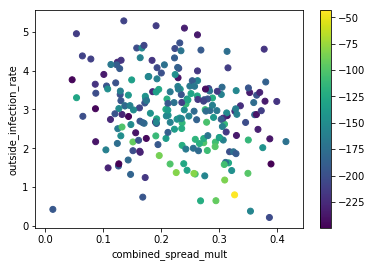

In [35]:
plt.scatter(subdf['combined_spread_mult'], subdf['outside_infection_rate_mult'],
           c=subdf['log_likelihood'])
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.colorbar()

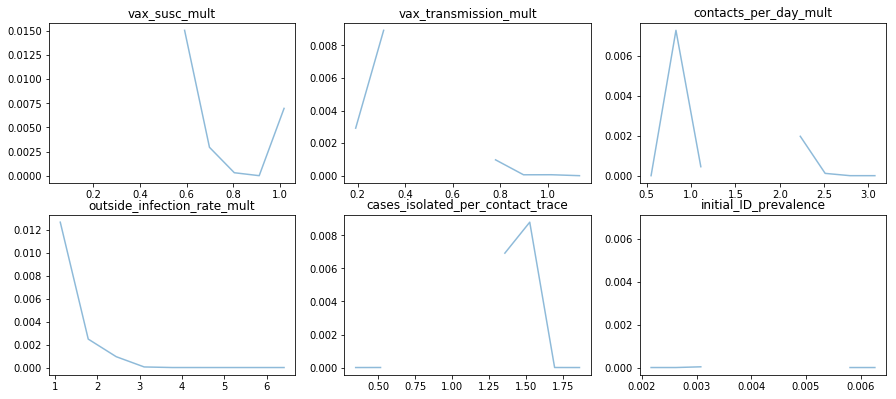

In [53]:
def estimate_marginal_dist(df, param, num_buckets=10):
    bin_boundaries = np.linspace(min(df[param]), max(df[param]), num=num_buckets+1)
    num_bins = len(bin_boundaries) - 1
    bin_centres = []
    bin_likelihoods = []
    for bin_start_idx in range((num_bins)):
        bin_start_val = bin_boundaries[bin_start_idx]
        bin_end_val = bin_boundaries[bin_start_idx + 1]
        bin_centres.append(0.5 * (bin_start_val + bin_end_val))
        
        subdf = df[(df[param] >= bin_start_val) & (df[param] < bin_end_val)]
        
        cum_likelihood = 0
        for loglik in subdf['log_likelihood']:
            cum_likelihood += np.exp(loglik)
        
        bin_likelihoods.append(cum_likelihood)
    return bin_centres, bin_likelihoods
        

plt.figure(figsize=(15,10))

for idx, param in enumerate(UNCERTAINTY_PARAMS):

    plt.subplot(3,3,idx+1)
    centres, likelihoods = estimate_marginal_dist(df, param)
    plt.plot(centres, 
                likelihoods,
               alpha=0.5)
    #plt.xlabel("Parameter Value")
    #plt.ylabel("Estimated Log Likelihood")
    plt.title("{}".format(param))